## MELANOMA DEEP LEARNING IMAGE CLASSIFICATION
### w251 - Fall 2021

![iphone capture](./iphone_capture.PNG)

In [112]:
import os
import time
import random
import argparse
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import sklearn
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from util import GradualWarmupSchedulerV2
#import apex
#from apex import amp
from dataset import get_df_test, get_transforms, MelanomaDataset
from models import Effnet_Melanoma, Resnest_Melanoma, Seresnext_Melanoma
from train import get_trans
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageOps

In [113]:
KERNEL_TYPE = '9c_meta_b3_768_512_ext_18ep'
DATA_DIR ='/data/melanoma-256'
DATA_FOLDER = 768
IMAGE_SIZE = 256
ENET_TYPE = 'efficientnet_b3'
BATCH_SIZE = 64
NUM_WORKERS = 1
OUT_DIM = 9
USE_AMP = True
DEBUG = True
MODEL_DIR = '/data/weights'
LOG_DIR = './logs'
SUB_DIR = './subs'
# choices=['best', 'best_20', 'final'], default="best")
EVAL = 'best' 
N_TEST = 8
# We only have one GPU on the ol' Jetson
CUDA_VISIBLE_DEVICES = '0'

In [114]:
os.makedirs(SUB_DIR, exist_ok=True)
os.environ['CUDA_VISIBLE_DEVICES'] = CUDA_VISIBLE_DEVICES

if ENET_TYPE == 'resnest101':
    ModelClass = Resnest_Melanoma
elif ENET_TYPE == 'seresnext101':
    ModelClass = Seresnext_Melanoma
elif 'efficientnet' in ENET_TYPE:
    ModelClass = Effnet_Melanoma
else:
    raise NotImplementedError()

DP = len(os.environ['CUDA_VISIBLE_DEVICES']) > 1

device = torch.device('cuda')

In [118]:
def main():

    df_test, mel_idx = get_df_test(
        KERNEL_TYPE,
        DATA_DIR
    )
    #print('printing df_test')
    #print(df_test)

    transforms_train, transforms_val = get_transforms(IMAGE_SIZE)

    #if DEBUG:
    #    df_test = df_test.sample(BATCH_SIZE * 3)
    dataset_test = MelanomaDataset(df_test, 'test', transform=transforms_val)
    test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    # load model
    models = []
    for fold in range(5):

        if EVAL == 'best':
            model_file =  os.path.join(MODEL_DIR, 'best_model.pth') 
        elif EVAL == 'best_20': 
            model_file = os.path.join(MODEL_DIR, 'best_20_model.pth')
        if EVAL == 'final':
            model_file = os.path.join(MODEL_DIR, 'final_model.pth')

        model = ModelClass(
            ENET_TYPE,
            out_dim=OUT_DIM
        )
        model = model.to(device)

        try:  # single GPU model_file
            model.load_state_dict(torch.load(model_file), strict=True)
        except:  # multi GPU model_file
            state_dict = torch.load(model_file)
            state_dict = {k[7:] if k.startswith('module.') else k: state_dict[k] for k in state_dict.keys()}
            model.load_state_dict(state_dict, strict=True)
        
        if len(os.environ['CUDA_VISIBLE_DEVICES']) > 1:
            model = torch.nn.DataParallel(model)

        model.eval()
        models.append(model)

    # predict
    PROBS = []
    with torch.no_grad():
        for (data) in tqdm(test_loader):
            data = data.to(device)
            probs = torch.zeros((data.shape[0], OUT_DIM)).to(device)
            for model in models:
                for I in range(N_TEST):
                    l = model(get_trans(data, I))
                    probs += l.softmax(1)

            probs /= N_TEST
            probs /= len(models)

            PROBS.append(probs.detach().cpu())

    PROBS = torch.cat(PROBS).numpy()

    # save cvs
    df_test['target'] = PROBS[:, mel_idx]
    df_test[['image_name', 'target']].to_csv(os.path.join(SUB_DIR, 'results.csv'), index=False)
    
    images = df_test['filepath']
    
    print("")
    
    print("OUTPUT RESULTS")
    
    fig = plt.figure(figsize=(20,5))
    for i in range(len(images)):
        ax = fig.add_subplot(1, len(images), i+1)
        ax.axis('off')
        img = Image.open(images[i])
        if df_test['target'][i] < .005:
            border_img = ImageOps.expand(img, border=25, fill='lightgreen')
        else:
            border_img = ImageOps.expand(img, border=25, fill='indianred')
        imgplot = plt.imshow(border_img)
        ax.set_title(str(round(float(df_test['target'][i]),4)))

## CAPTURING IMAGES FOR DIAGNOSIS


INPUT IMAGES FOR DIAGOSIS


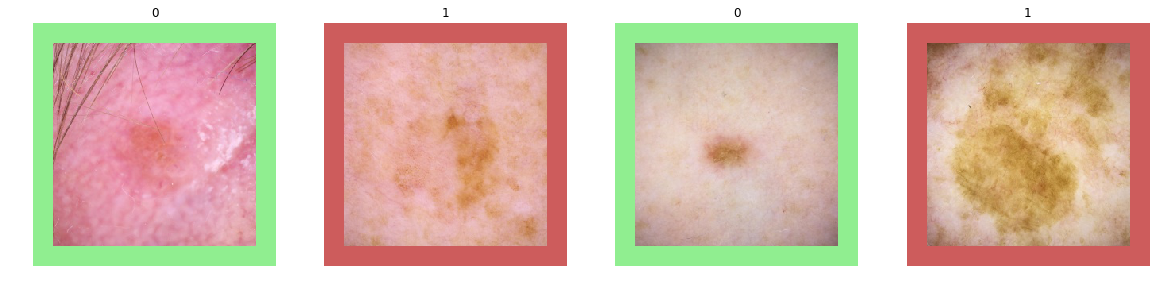

In [119]:
df_test, mel_idx = get_df_test(
    KERNEL_TYPE,
    DATA_DIR
)
#print('printing df_test')
#print(df_test)

images = df_test['filepath']

print("INPUT IMAGES FOR DIAGOSIS")
fig = plt.figure(figsize=(20,5))
for i in range(len(images)):
    ax = fig.add_subplot(1, len(images), i+1)
    ax.axis('off')
    img = Image.open(images[i])
    if df_test['target'][i] < 1:
        border_img = ImageOps.expand(img, border=25, fill='lightgreen')
    else:
        border_img = ImageOps.expand(img, border=25, fill='indianred')
    imgplot = plt.imshow(border_img)
    ax.set_title(df_test['target'][i])

## SCANNING IMAGES FOR MELANOMA

In [ ]:
main()